## [1. Import Needed Modules](#import) ##
## [2. Read in images and create a dataframe of image paths and class labels](#makedf) ## 
## [3. Balance the train_df dataframe using trim function](#trim) ##
## [4. Create train, test and validation generators](#generators) ## 
## [5. Create a function to show Training Image Samples](#show) ## 
## [6. Create the Model](#model) ## 
## [7. Create a custom Keras callback to continue or halt training](#callback) ## 
## [8. Instantiate custom callback and create callbacks to control learning rate and early stopping](#callbacks) ##
## [9. Train the model](#train) ##
## [10. Define a function to plot the training data](#plot) ##
## [11. Make predictions on test set, create Confusion Matrix and Classification Report](#result) ##
## [12 Save the model](#save) ##
## [13 Analysis of Model Results](#results) ##




<a id="import"></a>
# <center>Import Need Modules</center>

In [1]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model



<a id="makedf"></a>
# <center>Read in images and create a dataframe of image paths and class labels</center>


In [2]:
train_dir=r'../input/tomatoleaf/tomato/train'
valid_dir=r'../input/tomatoleaf/tomato/val'
for d in [train_dir, valid_dir]:
    filepaths = []
    labels=[] 
    classlist=sorted(os.listdir(d))
    for klass in classlist:
        label=klass.split('__')[1]
        classpath=os.path.join(d, klass)
        flist=sorted(os.listdir(classpath))
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)            
            labels.append(label)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')        
    if d == train_dir:
        df=pd.concat([Fseries, Lseries], axis=1)
    else:
        valid_df=pd.concat([Fseries, Lseries], axis=1)
train_df, test_df=train_test_split(df, train_size=.9, shuffle=True, random_state=123, stratify=df['labels'])   
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)
# lets get the average height and width of a sample of the train images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

train_df lenght:  9000   test_df length:  1000   valid_df length:  1000
The number of classes in the dataset is:  10
            CLASS               IMAGE COUNT 
       _Bacterial_spot              900     
        _Early_blight               900     
         _Late_blight               900     
          _Leaf_Mold                900     
     _Septoria_leaf_spot            900     
_Spider_mites Two-spotted_spider_mite      900     
         _Target_Spot               900     
_Tomato_Yellow_Leaf_Curl_Virus      900     
     _Tomato_mosaic_virus           900     
           _healthy                 900     
_Bacterial_spot  has the most images=  900   _Bacterial_spot  has the least images=  900
average height=  256  average width=  256 aspect ratio=  1.0


<a id="trim"></a>
# <center>Trim the dataset to balance he class samples</center>
### The trim function defined below takes in a dataframe and integers max_samples and min_samples plus
### a column name. It returns a dataframe where each class have no more than max_samples images in
### any class. If a class has less than min_samples images the class is excluded from the dataframe.

In [3]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    return trimmed_df

max_samples=200 # since each class has more than 200 images all classes will be trimmed to have 200 images per class
min_samples=200
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

after trimming, the maximum samples in any class is now  200  and the minimum samples in any class is  200


<a id="generators"></a>
# <center>Create the train_gen, test_gen final_test_gen and valid_gen</center>

In [4]:
working_dir=r'./'
img_size=(256,256)
batch_size=30 # We will use and EfficientetB3 model, with image size of (200, 250) this size should not cause resource error
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2 )
t_and_v_gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 2000 validated image filenames belonging to 10 classes.          for train generator 
Found 1000 validated image filenames belonging to 10 classes.          for valid generator 
Found 1000 validated image filenames belonging to 10 classes.          for test generator 
test batch size:  50   test steps:  20  number of classes :  10


<a id="show"></a>
# <center>Create a function to show example training images</center>

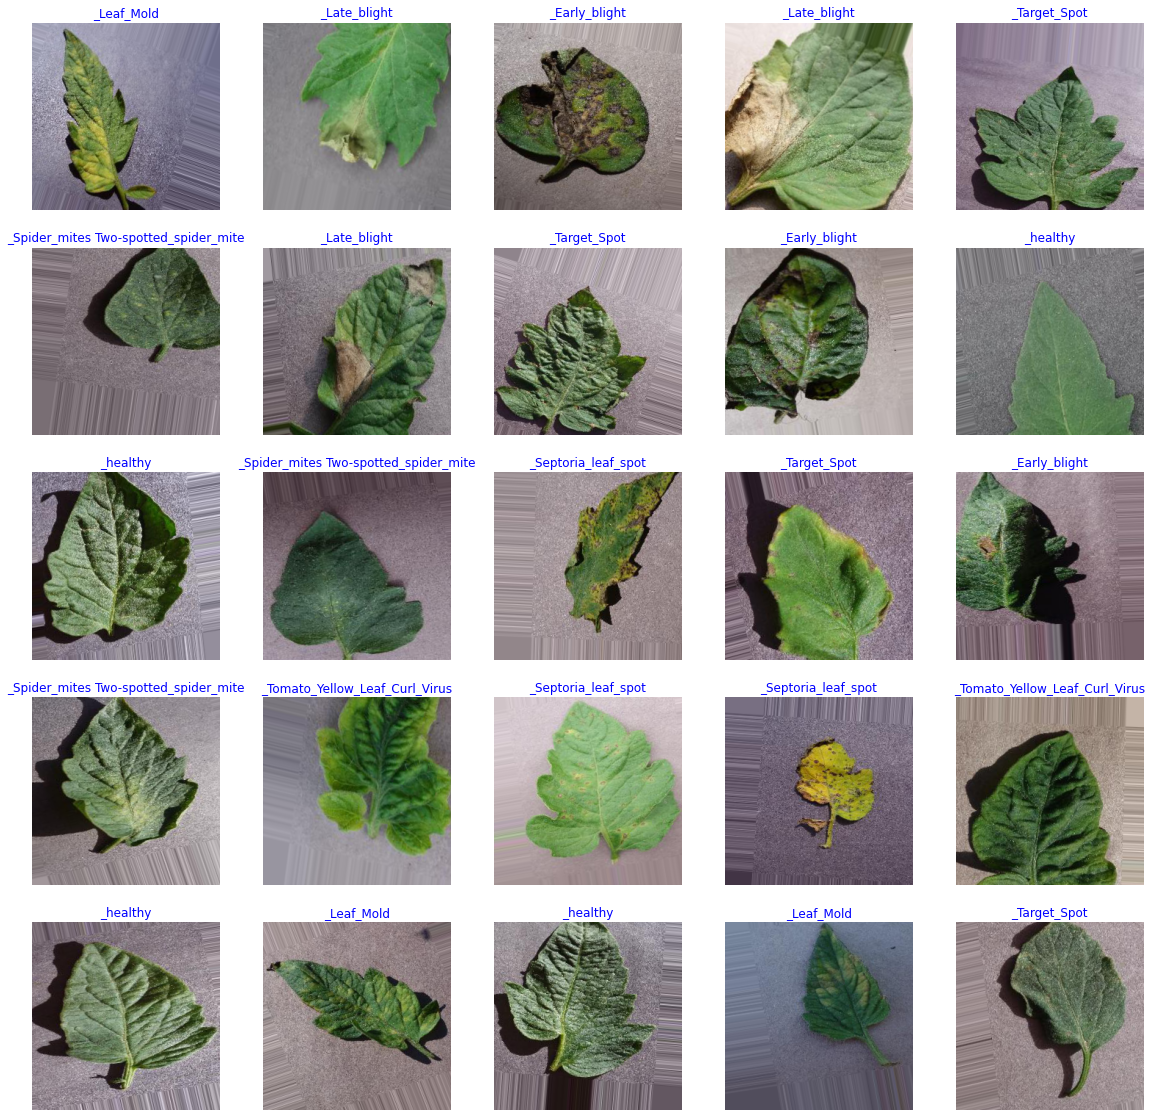

In [5]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

<a id="model"></a>
# <center>Create a model using transfer learning with EfficientNetB3</center>
### NOTE experts advise you make the base model initially not trainable. Then train for some number of epochs
### then fine tune model by making base model trainable and run more epochs
### I have found this to be WRONG!!!!
### Making the base model trainable from the outset leads to faster convegence and a lower validation loss
### for the same number of total epochs!

In [6]:
img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB3'
base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)       
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001 # start with this learning rate
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

43950080/43941136 [==============================] - 1s 0us/step


<a id="callback"></a>
# <center>Create a custom Keras callback to continue or halt training</center>

In [7]:
class ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training     
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)

<a id="callbacks"></a>
# <center>Instantiate custom callback and create 2 callbacks to control learning rate and early stop

In [8]:
epochs=40
ask_epoch=5
ask=ASK(model, epochs,  ask_epoch)
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, verbose=1,restore_best_weights=True)
callbacks=[rlronp, estop, ask]

<a id="train"></a>
# <center>Train the model
### Note unlike how you are told it is BETTER to make the base model trainable from the outset
### It will converge faster and have a lower validation losss

In [9]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 5  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/40
67/67 [==============================] - 86s 982ms/step - loss: 8.4954 - accuracy: 0.6350 - val_loss: 8.9850 - val_accuracy: 0.5610
Epoch 2/40
67/67 [==============================] - 46s 684ms/step - loss: 6.6534 - accuracy: 0.8830 - val_loss: 6.4893 - val_accuracy: 0.8190
Epoch 3/40
67/67 [==============================] - 47s 691ms/step - loss: 5.5652 - accuracy: 0.9270 - val_loss: 5.2256 - val_accuracy: 0.8980
Epoch 4/40
67/67 [==============================] - 46s 681ms/step - loss: 4.6535 - accuracy: 0.9560 - val_loss: 4.3335 - val_accuracy: 0.9390
Epoch 5/40
67/67 [==============================] - 47s 693ms/step - loss: 3.9138 - accuracy: 0.9675 - val_loss: 3.6445 - val_accuracy: 0.9490

 Enter H to end training or  an integer for the number of additional epochs to run then ask again


 5


you entered  5  Training will continue to epoch  10
Epoch 6/40
67/67 [==============================] - 46s 687ms/step - loss: 3.2853 - accuracy: 0.9770 - val_loss: 3.0518 - val_accuracy: 0.9530
Epoch 7/40
67/67 [==============================] - 46s 684ms/step - loss: 2.7637 - accuracy: 0.9780 - val_loss: 2.5602 - val_accuracy: 0.9580
Epoch 8/40
67/67 [==============================] - 47s 693ms/step - loss: 2.3162 - accuracy: 0.9825 - val_loss: 2.1486 - val_accuracy: 0.9520
Epoch 9/40
67/67 [==============================] - 46s 684ms/step - loss: 1.9339 - accuracy: 0.9865 - val_loss: 1.8086 - val_accuracy: 0.9630
Epoch 10/40
67/67 [==============================] - 46s 689ms/step - loss: 1.6055 - accuracy: 0.9920 - val_loss: 1.5195 - val_accuracy: 0.9550

 Enter H to end training or  an integer for the number of additional epochs to run then ask again


 2


you entered  2  Training will continue to epoch  12
Epoch 11/40
67/67 [==============================] - 46s 684ms/step - loss: 1.3439 - accuracy: 0.9915 - val_loss: 1.2739 - val_accuracy: 0.9600
Epoch 12/40
67/67 [==============================] - 46s 688ms/step - loss: 1.1281 - accuracy: 0.9920 - val_loss: 1.0630 - val_accuracy: 0.9690

 Enter H to end training or  an integer for the number of additional epochs to run then ask again


 h


you entered  h  Training halted on epoch  12  due to user input

training elapsed time was 0.0 hours, 10.0 minutes, 27.56 seconds)


<a id="plot"></a>
# <center>Define a function to plot the training data

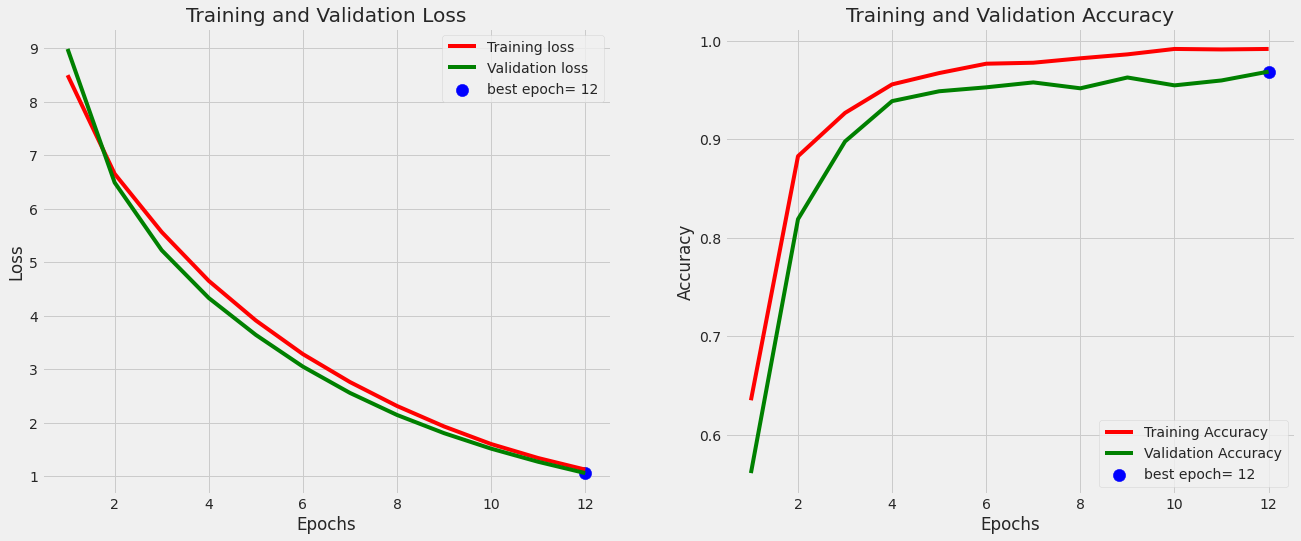

In [10]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    
tr_plot(history,0)

<a id="result"></a>
# <center>Make Predictions on the test set</a>
### Define a function which takes in a test generator and an integer test_steps
### and generates predictions on the test set including a confusion matric
### and a classification report

20/20 [==============================] - 11s 418ms/step
there were 18 in 1000 tests for an accuracy of  98.20


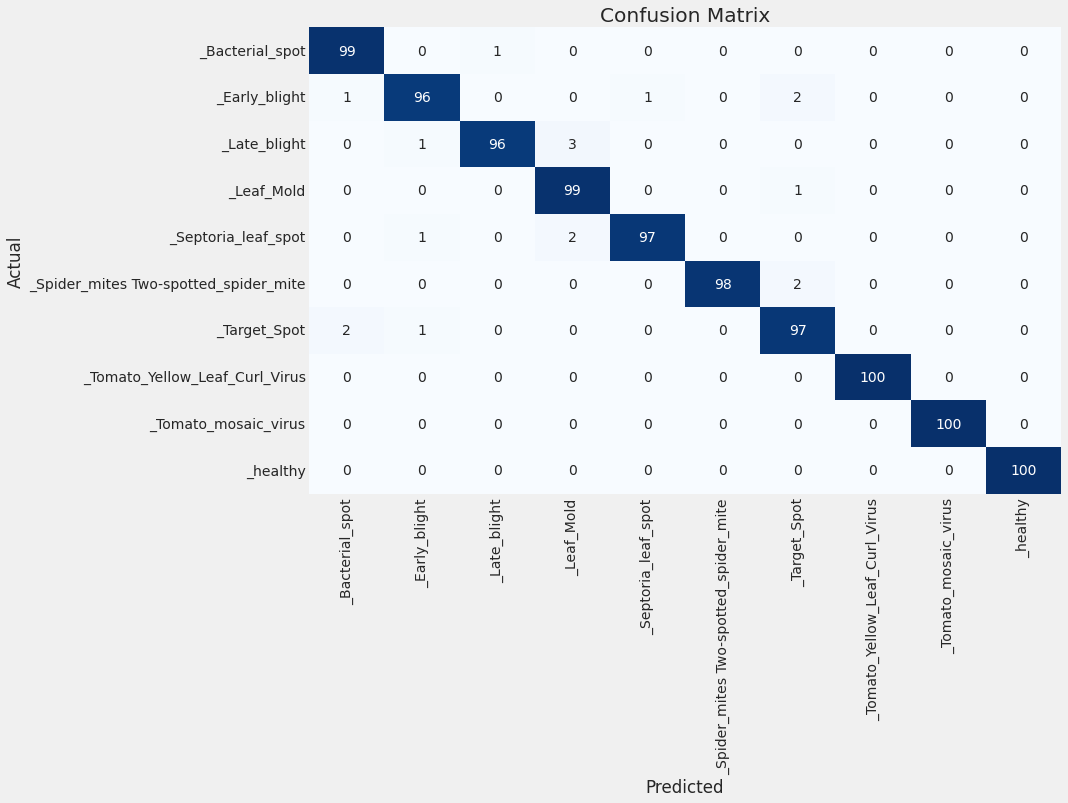

Classification Report:
----------------------
                                        precision    recall  f1-score   support

                      _Bacterial_spot     0.9706    0.9900    0.9802       100
                        _Early_blight     0.9697    0.9600    0.9648       100
                         _Late_blight     0.9897    0.9600    0.9746       100
                           _Leaf_Mold     0.9519    0.9900    0.9706       100
                  _Septoria_leaf_spot     0.9898    0.9700    0.9798       100
_Spider_mites Two-spotted_spider_mite     1.0000    0.9800    0.9899       100
                         _Target_Spot     0.9510    0.9700    0.9604       100
       _Tomato_Yellow_Leaf_Curl_Virus     1.0000    1.0000    1.0000       100
                 _Tomato_mosaic_virus     1.0000    1.0000    1.0000       100
                             _healthy     1.0000    1.0000    1.0000       100

                             accuracy                         0.9820      1000
   

In [11]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(train_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, steps=test_steps, verbose=1) # predict on the test set
    tests=len(preds)
    for i, p in enumerate(preds):
            pred_index=np.argmax(p)         
            true_index=test_gen.labels[i]  # labels are integer values
            if pred_index != true_index: # a misclassification has occurred                                           
                errors=errors + 1
            y_pred.append(pred_index)
    acc=( 1-errors/tests) * 100
    print(f'there were {errors} in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)

<a id="save"></a>
# <center>Save the model

In [12]:
subject='tomatoes' 
acc=str(( 1-errors/tests) * 100)
index=acc.rfind('.')
acc=acc[:index + 3]
save_id= subject + '_' + str(acc) + '.h5' 
model_save_loc=os.path.join(working_dir, save_id)
model.save(model_save_loc)
print ('model was saved as ' , model_save_loc ) 
   

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


model was saved as  ./scenes_98.2.h5


<a id="results"></a>
# <center>Analysis of Model Performance
In order to reduce training time the number of samples per class was limited to 150 images. We could have
used the trim function with max_samples=198 to get better training accuracy. The image size of the original images
was 600 X 600 but the model was trained with 200 X 200 images again to reduce training time. Overall the model
did well with an average F1 score of 94.5 %. We ran for 12 epochs and the validation loss was still decreasing with
about a 8% reduction in epoch 12. So we could run more epochs and probably acieve a better F1 score.